# Градиентный спуск с обратным распространением ошибки

### Обозначения
- $L$ - эмпирический риск
- $l$ - $l$-й слой сети
- $w_{ij}^l$ - вес $l$-го линейного слоя
- $\sigma$ - функция активации
- $x_0 \equiv s_0$ - входной вектор
- $x_j^l = \sum_i {w_{ij}^l s_i^{l-1}} = f(w_{ij}^l)$ - линейная комбинация, выход линейного слоя
- $s_j^l = \sigma (x_j^l)$ - выход функции активации $l$-го слоя, вход $(l+1)$-го слоя
- $\eta$ - скорость обучения

### Градиентный спуск
$$ \Delta w_{ij} = -\eta \frac {\partial L} {\partial w_{ij}} $$

Для всех слоев требуется посчитать $\frac {\partial L} {\partial w_{ij}}$

### Для последнего слоя

$$ s_j^l \equiv \hat y_j $$

$$L = L(s_j^l, y_j) = L(\sigma (x_j^l), y_j)= L(\sigma (f(w_{ij}^l)), y_j)$$

Раскрываем по правилу дифференцирования сложной функции:

$$
\frac {\partial L} {\partial w_{ij}^l} = 
\frac {\partial L} {\partial s_j^l}
\frac {\partial s_j^l} {\partial w_{ij}^l} =
\frac {\partial L} {\partial s_j^l}
\frac {\partial s_j^l} {\partial x_j^l}
\frac {\partial x_j^l} {\partial w_{ij}^l}
$$

И вычисляем все частные производные:

$$
\frac {\partial L} {\partial s_j^l} \equiv \frac {\partial L} {\partial \hat y_j} = \delta_j^l
$$
- (производная эмпирического риска. Зависит только от $\hat y_j$)

$$
\frac {\partial s_j^l} {\partial x_j^l} =
\frac {\partial \sigma (x_j^l)} {\partial x_j^l} = \sigma' (x_j^l)
$$
- (производная функции активации в точке. Зависит только от $x_j^l$)

$$
\frac {\partial x_j^l} {\partial w_{ij}^l} = 
\frac {\partial \sum_i {w_{ij}^l s_i^{l-1}}} {\partial w_{ij}^l} = s_i^{l-1}
$$
- (вход слоя)

Итого:
$$
\frac {\partial L} {\partial w_{ij}^l} =
\delta_j^l \times \sigma' (x_j^l) \times s_i^{l-1}
$$

Также знаем:
$$
\frac {\partial L} {\partial x_j^l} = 
\frac {\partial L} {\partial s_j^l}
\frac {\partial s_j^l} {\partial x_j^l} =
\delta_j^l \times \sigma' (x_j^l)
$$
- (потребуется для следующего слоя)

### Для внутренних слоев

Здесь уже требуется сумма по всем нейронам $x_k^{l+1}$:
$$
\frac {\partial L} {\partial w_{ij}^l} = \sum_k
\frac {\partial L} {\partial x_k^{l+1}}
\frac {\partial x_k^{l+1}} {\partial x_j^l}
\frac {\partial x_j^l} {\partial w_{ij}^l}
$$

Последний множитель не зависит от $k$, выносим его за сумму. И раскрываем вторую производную по выходу слоя $s_j^l$
$$
\frac {\partial L} {\partial w_{ij}^l} = 
\frac {\partial x_j^l} {\partial w_{ij}^l}
\sum_k
\frac {\partial L} {\partial x_k^{l+1}}
\frac {\partial x_k^{l+1}} {\partial s_j^l} 
\frac {\partial s_j^l} {\partial x_j^l}
$$

И вычисляем все частные производные:
$$
\frac {\partial x_j^l} {\partial w_{ij}^l} = s_i^{l-1}
$$
- (Аналогично предыдущему случаю, вход слоя)

$$
\frac {\partial s_j^l} {\partial x_j^l} = \sigma' (x_j^l)
$$
- (Аналогично предыдущему слою, производная функции активации в точке)

$$
\frac {\partial L} {\partial x_k^{l+1}} = \delta_k^{l+1} \times \sigma' (x_k^{l+1})
$$
- (Знаем ответ после вычислений на предыдущем слое)
$$
\frac {\partial x_k^{l+1}} {\partial s_j^l} = 
\frac {\partial \sum_i {w_{ik}^{l+1} s_i^l}} {\partial s_j^l} = 
w_{jk}^{l+1}
$$
- (вес, соответствующий $j$-му входу)

Итого:
$$
\frac {\partial L} {\partial w_{ij}^l} = 
s_i^{l-1} \times \sum_k {
\delta_k^{l+1} \times
\sigma'(x_k^{l+1}) \times
w_{jk}^{l+1} \times
\sigma'(x_j^l) }
$$

# Реализация алгоритма обратного распространения ошибки

In [7]:
import numpy as np, numpy.random as nr
import pandas as pd
import matplotlib.pyplot as plt

# Функция активации

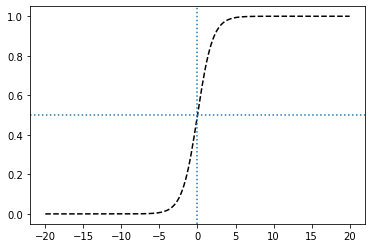

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

wing = 20
x_sigmoid = np.linspace(-wing, wing, wing * 10 + 1)
plt.plot(x_sigmoid, sigmoid(x_sigmoid), '--k')
plt.axvline(0,   linestyle=':')
_ = plt.axhline(0.5, linestyle=':')

# Данные: XOR (с компонентой для сдвига)

In [9]:
def get_xor_data():
    x = np.array([
        [0, 0, 1], [0, 1, 1],
        [1, 0, 1], [1, 1, 1]
    ])
    y = np.array([[0, 1, 1, 0]]).T
    return x, y

x, y = get_xor_data()

# Параметры обучения

In [42]:
lr = 2
n_epochs = 600
loss_history = pd.DataFrame(index=range(n_epochs), columns=['vanilla', 'clipped'], dtype=float)

# Два линейных слоя с инициализацией весов

In [50]:
nr.seed(0)
w0 = 2 * nr.random((3, 2)) - 1
w1 = 2 * nr.random((2, 1)) - 1
print(f'1st layer contains {w0.size} weights, 2nd layer contains {w1.size} weights')

1st layer contains 6 weights, 2nd layer contains 2 weights


In [51]:
use_clip = True
column = 'clipped' if use_clip else 'vanilla'

s0 = x
for i in range(n_epochs):
    # forward
    s1 = sigmoid(s0 @ w0)
    s2 = sigmoid(s1 @ w1)

    # loss (dL/ds2)
    diff = y - s2
    loss_history.loc[i, column] = (diff ** 2).mean()

    # backward
    ## dσ/dx
    ds1 = s1 * (1 - s1)
    ds2 = s2 * (1 - s2)    
    
    ## dL/dx
    dx2 = ds2 * diff
    dx1 = ds1 * (dx2 @ w1.T)
    
    ## Compute gradients
    grad_1 = s1.T @ dx2
    grad_0 = s0.T @ dx1
    
    if use_clip:
        clip_value = 0.05
        grad_1 = np.clip(grad_1, -clip_value, clip_value)
        grad_0 = np.clip(grad_0, -clip_value, clip_value)
    
    # step
    w1 += lr * grad_1
    w0 += lr * grad_0

**NOTE:** в коде есть неточность (не влияющая здесь на поведение), которую при реализации задания нужно будет найти и исправить

Final loss:
 vanilla    0.016946
clipped    0.016577
Name: 599, dtype: float64


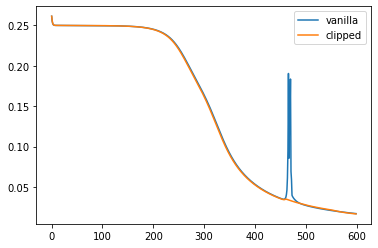

In [52]:
print(f'Final loss:\n', loss_history.iloc[-1])
_ = loss_history.plot()